### Mạng nơ ron tích chập LeNet
- Trong lần đầu làm việc với dữ liệu ảnh, ta đã áp dựng một MLP cho ảnh quần áo trong bộ dữ liệu Fashion-MNIST. Mỗi ảnh trong Fashion-MNIST là một ma trận hai chiều có kích thước 28x28. Để tương thích với đầu vào dạng vector một chiều với độ đai cố định của perceptron đa tầng, đầu tiên ta trải phẳng từng ảnh và thu được các vector chiều dài 784 trước khi xử lý chúng với một chuỗi các tầng kết nối dầy đủ.
- Bâu giờ ta có các tầng tích chập, ta có thể giữ nguyên ảnh đầu vào ở dạng không gian hai chiều như ảnh gốc và xử lý chúng với một chuỗi các tầng tích chập liên tiếp. Hơn nữa, vì ta đang sử dụng các tầng tích chập, __số lượng tham số cần thiết sẽ giảm đi đáng kể__.
#### 1. LeNet
- Ta có thể xem LeNet gồm hai phần:
    1. Một khối gồm các tầng tích chập
    2. Một khối các tầng kết nối đầy đủ.

    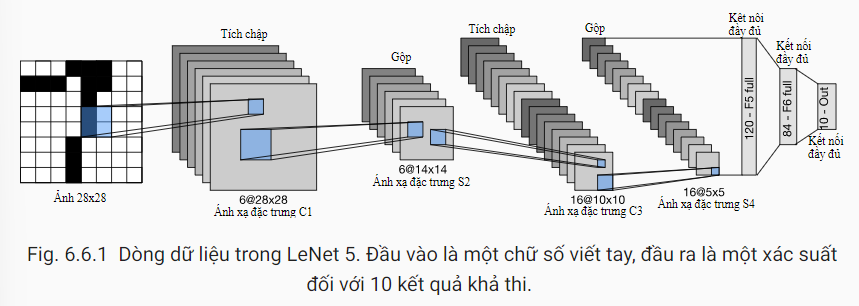

- Các đơn vị cơ bản trong khối tích chập là một tầng tích chập và một lớp gộp trung bình theo sau (lưu ý rằng gộp cực đại hoạt động tốt hơn). Tầng tích chập được sử dụng để nhận dạng các mẫu không gian trong ảnh, chẳng hạn như các đường cạnh và các bộ phận của vật thể, lớp gộp trung bình phía sau dùng để giảm số chiều. Khối tầng tích chập tạo nên từ việc xếp chồng các khối nhỏ gồm hai đơn vị cơ bản này.
- Mỗi tầng tích chập sử dụng hạt nhân có kích thước 5x5 và xử lý đầu ra với hàm kích hoat sigmoid (nên dùng ReLU). Tầng tích chập đầu tiên có 6 kênh đầu ra và tầng tích chập thứ hai tăng độ sâu kênh hơn nữa lên 16.
- Tuy nhiên, cùng với sự gia tăng số lượng kênh này, chiều cao và chiều rộng lại giảm đáng kể. Do đó, việc tăng số lượng kênh đầu ra làm cho kích thước tham số của hai tầng tích chập tương tự nhau. 
- Hai lớp gộp trung bình có kích thước 2x2 và sải bước bằng 2 (điều này có nghĩa là chúng không chồng chéo). Nói cách khác, lớp gộp giảm kích thước của các biểu diễn còn một phần tư kích thước trước khi gộp.
- Đầu ra của khối tích chập có kích thước được xác định bằng kích thước batch, kênh, chiều cao, chiều rộng. Trước khi chuyển đầu ra của khối tích chập sang khối kết nối đầy đủ, ta phải trải phẳng từng mẫu trong minibatch. Nói cách khác, ta biến đổi đầu vào 4D thành 2D tương thích với các tầng kết nối đầy đủ. 

- Khối tầng kết nối đầy đủ: Gồm 3 tầng
    + Số lượng đầu ra lần lượt là 120, 84 và 10. 
    + Tầng đầu ra 10 chiều tương ứng với số lượng các lớp đầu ra khả thi (10 chữ số từ 0 đến 9)

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn
npx.set_np()

In [2]:
net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding = 2, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides = 2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides = 2),
    # Dense will transform the input of the shape (
    # batch_size, channel, height, width
    # ) into the shape (batch_size, channel * height * width) automatically by default

    nn.Dense(120, activation = 'sigmoid'),
    nn.Dense(84, activation='sigmoid'),
    nn.Dense(10)
)

So với mạng ban đầu, ta đã thay thế kích hoạt Gauss ở tầng cuối cùng bằng một tầng kết nối đầy đủ thông thường mà thường dễ huấn luyện hơn đáng kể. Ngoại trừ điểm đó thì mạng này giống với định nghĩa gốc của LeNet5.
Tiếp theo, ta xem ví dụ sau. Ta đưa vào mạng một mẫu đơn kênh kích thước 28x28 và thực hiện một lượt truyền xuôi qua các tầng và in kích thước đầu ra ở mỗi tầng để có thể hiểu rõ những gì đang xảy ra bên trong:


In [3]:
X = np.random.uniform(size = (1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(f"{layer.name}, output shape: {X.shape}")

conv0, output shape: (1, 6, 28, 28)
pool0, output shape: (1, 6, 14, 14)
conv1, output shape: (1, 16, 10, 10)
pool1, output shape: (1, 16, 5, 5)
dense0, output shape: (1, 120)
dense1, output shape: (1, 84)
dense2, output shape: (1, 10)


- Chiều cao và chiều rộng của biểu diễn sau mỗi tầng trong toàn bộ khối tích chập sẽ giảm theo chiều sâu của mạng (so với chiều cao và chiều rộng của biểu diễn ở tầng trước):
    + Tầng tích chập đầu tiên sử dụng một hạt nhân với chiều cao và chiều rộng là 5 rồi đệm thêm hai đơn vị điểm ảnh để giữ nguyên kích thước đầu vào.
    + Tầng tích chập thứ hai dùng cùng một hạt nhân với kích thước 5x5 mà không sử dụng giá trị đệm thêm vào dẫn đến việc chiều cao và chiều rộng giảm thêm 4 đơn vị điểm ảnh. 
    + Ngoài ra, mỗi tầng gộp sẽ làm giảm đi một nửa chiều cao và chiều rộng của đặc trưng ánh xạ đầu vào.
    + Tuy nhiên, khi ta đi theo chiều sâu của mạng, số kênh sẽ tăng lần lượt theo từng tầng. Từ 1 kênh của dữ liệu đầu vào lên tới 6 kênh sau tầng tích chập thứ nhất và 16 kênh sau tầng tích chập thứ hai. 
    + Sau đó, giảm số chiều lần lượt qua từng tầng kết nối đầy đủ đến khi trả về một đầu ra có kích thước bằng số lượng lớp của hình ảnh.

#### 2. Thu thập dữ liệu và huấn luyện
- Sau khi xây dựng mô hình, ta sẽ thực hiện thử nghiệm để xem chất lượng của mô hình LeNet. Tập dữ liệu Fashion-MNIST sẽ được dùng trong ví dụ này. Việc phân loại tập Fashion-MNIST sẽ khó hơn so với tập MNIST gốc mặc dù chúng đều chứa các ảnh có cùng kích thức 28x28.

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)

In [5]:
def train(net, train_iter, test_iter, num_epochs, lr):
    net.initialize(force_reinit=True, init = init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    animator = d2l.Animator(
        xlabel = 'epochs', ylabel='loss/acc',
        xlim = [1, num_epochs],
        legend = ['train_loss', 'train_acc', 'test_acc']
    )

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)

        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
            # animator.add([epoch + 1] * 3, [train_loss, train_acc, None])
        for X, y in test_iter:
            test_acc = d2l.accuracy(net(X), y) / len(y)
            break
        animator.add([epoch + 1] * 3, [train_loss, train_acc, test_acc])
    print(train_loss, train_acc, test_acc)


In [6]:
# train(net, train_iter, test_iter, 10, 0.9)


In [7]:
def train_epoch(net, train_iter, loss, trainer):
    metric = d2l.Accumulator(3)

    for X, y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        trainer.step(len(y))
        metric.add(l.sum(), d2l.accuracy(y_hat, y), len(y))
    
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, learning_rate, num_epochs):
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), optimizer='sgd', optimizer_params={
        'learning_rate':learning_rate
    })

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, trainer)
        for X, y in test_iter:
            test_acc = d2l.accuracy(net(X), y) / len(y)
            break
        print(train_loss, train_acc, test_acc)

net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding = 2, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides = 2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides = 2),
    # Dense will transform the input of the shape (
    # batch_size, channel, height, width
    # ) into the shape (batch_size, channel * height * width) automatically by default

    nn.Dense(120, activation = 'sigmoid'),
    nn.Dense(84, activation='sigmoid'),
    nn.Dense(10)
)

# net.initialize(init = init.Xavier(), force_reinit=True)
# train(net, train_iter, test_iter, 0.9, 10)

In [9]:
# Save parameters of LeNet5
# net.save_parameters('LeNet_params')

# Load parameters
net.load_parameters('LeNet_params')

# test accuracy
d2l.evaluate_accuracy(net, test_iter)

0.8426

array([<AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'dress'}>], dtype=object)

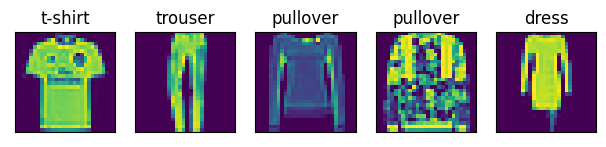

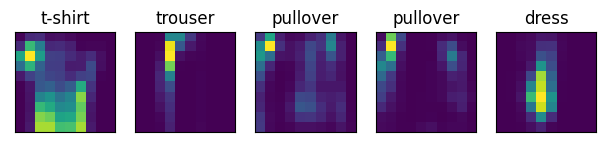

In [10]:
for X, y in test_iter:
    X = X[:5]
    y = y[:5]
    break
X.shape, y.shape

images = X.squeeze(1)
d2l.show_images(images, 1, 5, titles = d2l.get_fashion_mnist_labels(y))

# images after 1st activation layer
X1 = net[2](net[1](net[0](X)))
images = X1[:, :1, :, :].squeeze(1)
d2l.show_images(images, 1, 5, titles = d2l.get_fashion_mnist_labels(y))


In [11]:
net

Sequential(
  (0): Conv2D(1 -> 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(sigmoid))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(6 -> 16, kernel_size=(5, 5), stride=(1, 1), Activation(sigmoid))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Dense(400 -> 120, Activation(sigmoid))
  (5): Dense(120 -> 84, Activation(sigmoid))
  (6): Dense(84 -> 10, linear)
)

conv2
pool2
conv3
pool3


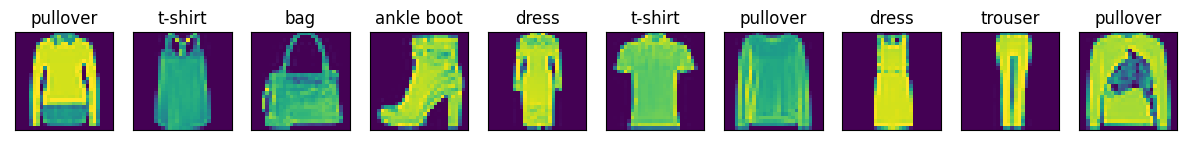

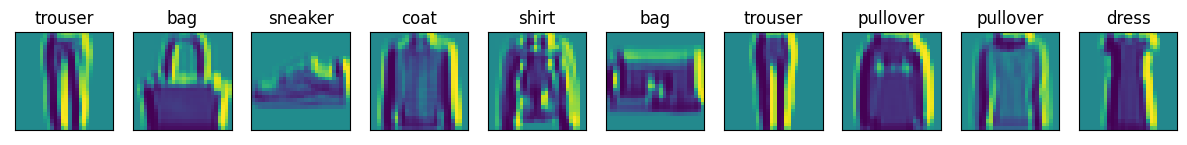

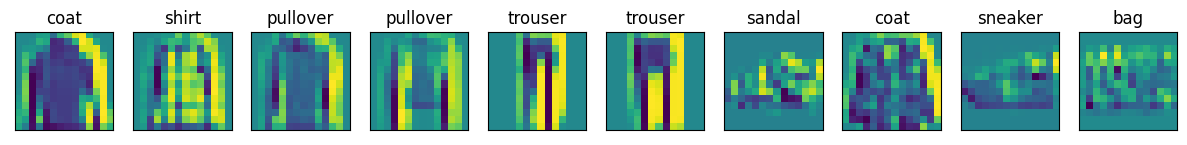

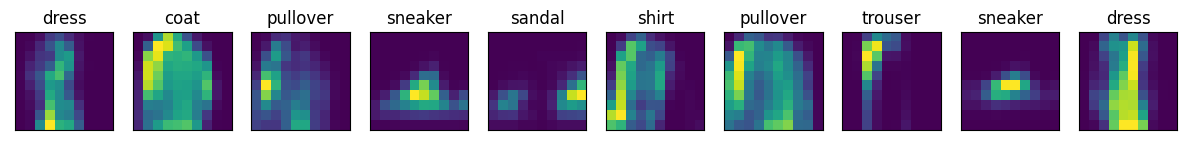

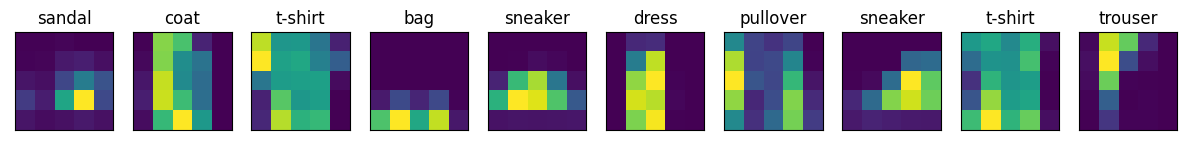

In [ ]:
def print_output(net, layer_index, data_iter, num_samples = 5):
    for X, y in data_iter:
        X = X[:num_samples]
        y = y[:num_samples]
        break
    
    if (layer_index == -1):
        images = X.squeeze(1)
        d2l.show_images(images, 1, num_samples, titles = d2l.get_fashion_mnist_labels(y))
    else:
        # images after 1st activation layer
        for i in range(layer_index + 1):
            X = net[i](X)
        images = X[:, :1, :, :].squeeze(1)
        d2l.show_images(images, 1, num_samples, titles = d2l.get_fashion_mnist_labels(y))

for i in range(-1, 4):
    if i != -1:
        print(net[i].name)
    print_output(net, i, train_iter, 10)